# Semantic argument structure probing

Participants:
- Yuliya Korotkova
- Kseniya Shikunova
- Yuliya Gorshkova
- Nellya Dzhubaeva

We propose a framework for semantic structure probing of Russian LMs. This framework consists of 4 experiments preformed on one dataset labeled with predicates and their arguments. Code and experiments are publicly available in our [GitHub](https://github.com/yuliya1324/data_for_workshop).

### Structure

1. Dataset EDA
2. Methods of probing:

  1. Case Probing via MLM
  2. Who gets more attention?
  3. Attention Map Similarity
  4. Hierarchical clustering

Requirements

In [ ]:
!git clone https://github.com/yuliya1324/data_for_workshop.git

In [ ]:
!pip install -r data_for_workshop/requirements.txt

In [ ]:
import numpy as np
import pandas as pd

## Roles Distribution

Предложения, которые вошли в датасет, взяты из "[Открытого корпуса](https://http://opencorpora.org)" и размечены вручную.

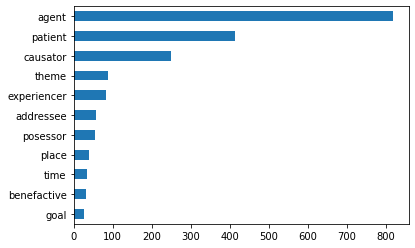

In [ ]:
df = pd.read_csv('./data_for_workshop/semantic_roles_data.csv', sep=',')
df.role.value_counts().sort_values().plot(kind = 'barh')

## Case Probing via MLM

**Цель** данного экспериента заключается в том, чтобы проверить понимание модели аргументной структуры предиката через маскирование аргументрв. Мы предположили, что если модель предсказывает слова в том же падеже, в котором стоит таргетный аргумент, то модель верно распознала аргументную структуру.

**Метод и данные**: Эксперимент проводился на моделях T5, Roberta, Bert (tiny, base, large). Таким образом, мы хотели сравнить encoder и encoder-decoder модели, а также модели разных размеров. Для проверки гипотезы аргументы были замаскированы, и модели предсказали по n токенов на месте масок. Дальше для каждого предложения предсказанные токены были отфильтрованы на существительные, и для каждого токена был получен его падеж. Для оценки качества использовалась accuracy метрика (доля верных падежей среди предсказанных токенов). Полученные результаты мы посчитали по семантическим ролям и усреднили по всему датасету.

In [ ]:
from data_for_workshop.yuokorotkova.mask_exp import MaskExperiment

In [ ]:
available_models = [
                        "google/mt5-small",
                        "sberbank-ai/ruRoberta-large",  
                        "cointegrated/rubert-tiny2", 
                        "DeepPavlov/rubert-base-cased", 
                        "sberbank-ai/ruBert-large"
                        ]
results = []

for model in available_models:
    mask_exp = MaskExperiment(model, "data_for_workshop/semantic_roles_data.csv", "cuda:0")
    result = mask_exp.run_experiment()
    df = pd.DataFrame(np.concatenate((result["by role"].values, result["average"]), axis=None).reshape(1, -1), columns=list(result["by role"].index) + ["average"])
    df["model"] = mask_exp.model_name
    results.append(df)

In [ ]:
results_df = pd.concat(results)

In [ ]:
results_df

,addressee,agent,benefactive,causator,experiencer,goal,patient,place,posessor,theme,time,average,model
0,0.536543,0.682972,0.587710,0.602659,0.689601,0.751877,0.533111,0.578818,0.530492,0.581753,0.700583,0.623838,google/mt5-small
0,0.565675,0.684308,0.600358,0.624638,0.602357,0.740812,0.585522,0.640497,0.560788,0.611932,0.695952,0.639408,sberbank-ai/ruRoberta-large
0,0.462986,0.581569,0.583333,0.551430,0.545817,0.699679,0.473884,0.649958,0.434661,0.547687,0.638730,0.547118,cointegrated/rubert-tiny2
0,0.669253,0.663950,0.670968,0.673233,0.604379,0.807692,0.623147,0.679313,0.516667,0.646338,0.644762,0.650808,sberbank-ai/ruBert-large
0,0.633333,0.724984,0.652688,0.677209,0.649751,0.824359,0.623307,0.685965,0.624993,0.647980,0.742812,0.683616,DeepPavlov/rubert-base-cased


In [ ]:
results_df.mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


addressee      0.573558
agent          0.667557
benefactive    0.619012
causator       0.625834
experiencer    0.618381
goal           0.764884
patient        0.567794
place          0.646910
posessor       0.533520
theme          0.607138
time           0.684568
average        0.628958
dtype: float64


**Результаты**:

В среднем модели предсказывают аргумент в верном падеже только в 63% случаев. Лучше всего справилась модель `DeepPavlov/rubert-base-cased` (0.68), а хуже всего - `cointegrated/rubert-tiny2` (0.55). При этом роль, которая распознается лучше всего это goal, а хуже всего posessor. Существенной разницы между моделями с разной архитектурой не замечено. 

## Who gets more attention?

**Целью** эксперимента является определить, есть ли различие в весах аттеншена для разных аргументов глагола. Предполагается, что модель должна для каждой роли присваивать наибольшие веса в разных головах и слоях. 

**Методы**: Эксперимент проводился на модели `sberbank-ai/ruBert-base`. Поскольку иногда слова разделялись на несколько токенов, было решено рассмотреть 3 варианта подсчета значения аттеншена между токенами одного слова: 
* считать среднее значение (mean);
* брать максимальное значение среди токенов (max);
* брать значение для первого токена (st).

В итоге получилось 9 вариантов, с разными вариантами подсчета аттеншена для глагола и аргумента.

Для каждого предложения были найдены значения на 12 слоях и в 12 головах. Затем данные усреднялись для каждого аргумента, после чего для каждой пары head-layer было найдено максимальное значение аттеншена и роль, которой это значение принадлежит. 

In [ ]:
from data_for_workshop.xmshikunova.attention_exp import *

In [ ]:
from tqdm.auto import tqdm
from statistics import mean
import matplotlib.pyplot as plt  
from matplotlib import colors

In [ ]:
from transformers import BertTokenizer, BertModel, BertConfig

model_version = 'sberbank-ai/ruBert-base'
model = BertModel.from_pretrained(model_version, output_attentions=True, num_attention_heads=12)
tokenizer = BertTokenizer.from_pretrained(model_version)

Downloading:   0%|          | 0.00/590 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/716M [00:00<?, ?B/s]

Some weights of the model checkpoint at sberbank-ai/ruBert-base were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

In [ ]:
role_df = pd.read_csv('./data_for_workshop/semantic_roles_data.csv', sep=',')

weighted_df_list = run_experiment(role_df, tokenizer, model, tqdm)  
# dict_keys(['vmean_amean', 'vmean_amax', 'vmean_ast', 'vmax_amean', 'vmax_amax', 'vmax_ast', 'vst_amean', 'vst_amax', 'vst_ast'])
# v - выбор значения аттеншена между токенами глагола, a - между токенами аргумента

df = weighted_df_list['vmean_amean']
roles = role_df.role.unique()

mean_dfs = to_mean(df, roles, mean)

colored_df = make_vizualization(mean_dfs, pd, plt, colors, roles)
colored_df

  0%|          | 0/1894 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

,head_0,head_1,head_2,head_3,head_4,head_5,head_6,head_7,head_8,head_9,head_10,head_11
0,goal,place,causator,causator,patient,goal,benefactive,causator,place,experiencer,place,posessor
1,experiencer,benefactive,place,agent,patient,posessor,agent,theme,experiencer,experiencer,place,experiencer
2,experiencer,experiencer,agent,time,experiencer,time,patient,experiencer,posessor,goal,experiencer,goal
3,experiencer,experiencer,patient,goal,patient,causator,agent,goal,causator,posessor,benefactive,theme
4,experiencer,patient,theme,experiencer,causator,posessor,experiencer,posessor,causator,time,experiencer,experiencer
5,posessor,posessor,posessor,experiencer,theme,causator,experiencer,patient,goal,experiencer,experiencer,theme
6,agent,agent,posessor,patient,posessor,patient,posessor,experiencer,experiencer,experiencer,place,patient
7,experiencer,experiencer,experiencer,experiencer,patient,agent,agent,agent,experiencer,experiencer,experiencer,goal
8,addressee,experiencer,addressee,patient,experiencer,patient,experiencer,posessor,experiencer,posessor,experiencer,patient
9,posessor,experiencer,experiencer,causator,experiencer,posessor,posessor,patient,experiencer,patient,experiencer,experiencer


**Результаты**: 

Как видно из таблицы, для каждой роли есть как минимум одна head-layer пара, где значение аттеншена выше, чем у остальных ролей. Цветом показана величина каждого значения относительно других. Можно заметить, что четырем ролям: agent, patient, posessor и experiencer уделяется наибольшее внимание. 

## Attention Map Similarity

Целью эксперимента являлась автоматическая реализация **поиска близких паттернов для карт внимания** (attention maps) разных семантических ролей.

Для этого были выполнены следующие действия:

1.   Получены **карты аттеншнов** от предикатов к их участникам (значения на всех слоях и всех голов);
2.   Для каждой семантической роли было получено значение **3 квартиля** всех n_layers * n_heads скоров;
3.   Для каждой семантической роли на каждой позиции аттеншна была высчитана доля примеров, **превосходящих это значение** -- таким образом, получена репрезентация карты внимания каждой роли.

Фреймворк включает в себя три метода для **оценки и визуализации** результата:

*   `.role_maps()` позволяет визуализировать карты для всех участников, а также общую карту, в виде heatmap;
*   `.role_similarity()` показывает карту сходства ролей, которое расчитывается как косинусная близость карт, выпрямленных в один вектор;
*   `.role_prediction_accuracy()` -- при вызове метода для каждого примера в датасете производится трансормация, описанная для ролей выше, затем с помощью косинусной близости находится наиболее близкая к каждому примеру роль; после этого для полученных предсказаний рассчитывается accuracy.



In [ ]:
from data_for_workshop.yuagorshkova.attn_map_exp import AttentionMapExperiment

In [ ]:
attention_map_experiment = AttentionMapExperiment("sberbank-ai/ruBert-large",
                                              "data_for_workshop/semantic_roles_data.csv")

attention_map_experiment.run_experiment()

Some weights of the model checkpoint at sberbank-ai/ruBert-large were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 1894/1894 [18:50<00:00,  1.68it/s]


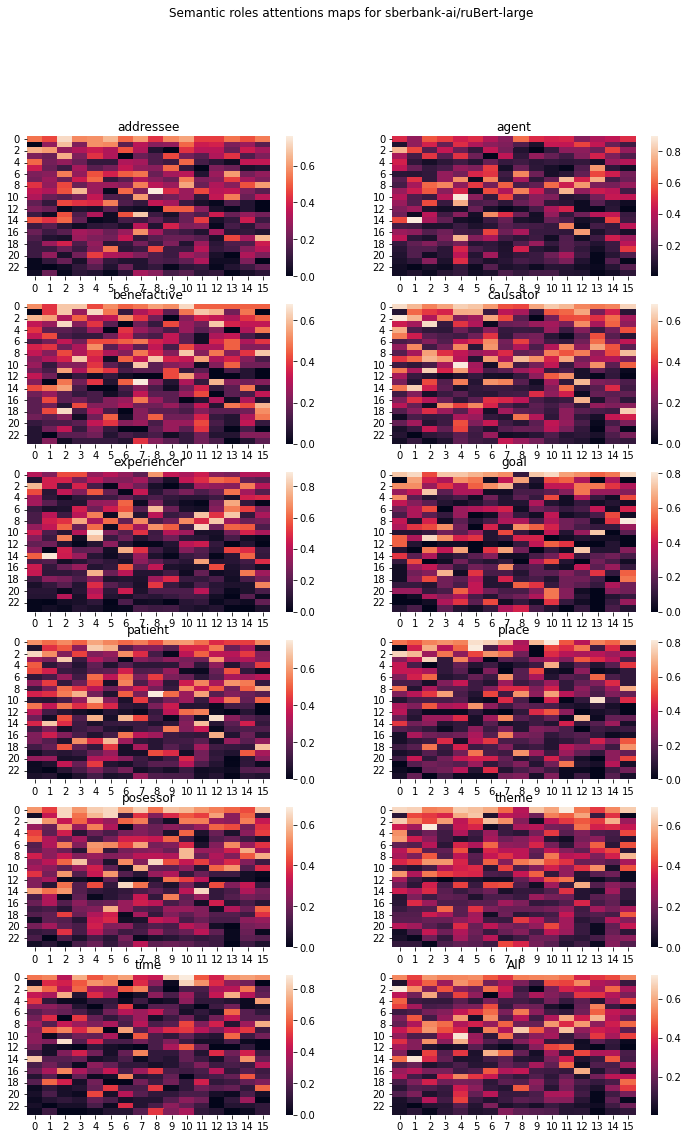

In [ ]:
attention_map_experiment.role_maps()

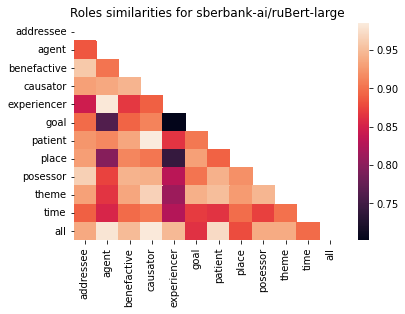

In [ ]:
attention_map_experiment.role_similarity()

In [ ]:
availible_models = attention_map_experiment.available_models
accuracies = []
for model_name in availible_models:
  am_experiment = AttentionMapExperiment(model_name, "data_for_workshop/semantic_roles_data.csv")
  am_experiment.run_experiment()
  accuracy = am_experiment.role_prediction_accuracy()
  accuracies.append(accuracy)

Some weights of the model checkpoint at cointegrated/rubert-tiny2 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 1894/1894 [00:19<00:00, 95.13it/s]
Some weights of the model checkpoint at DeepPavlov/rubert-base-

In [ ]:
for model_name, accuracy in zip(availible_models, accuracies):
  print(f"Role prediction accuracy using attentions data for {model_name} is {round(accuracy, 4)}")

Role prediction accuracy using attentions data for cointegrated/rubert-tiny2 is 0.2175
Role prediction accuracy using attentions data for DeepPavlov/rubert-base-cased is 0.2846
Role prediction accuracy using attentions data for sberbank-ai/ruBert-large is 0.3712


**Результаты**

Основываясь на результатах, полученных в ходе эксперимента, можно заметить что лучше всех по карте внимания роли предсказывает модель **ruBert-large**, а хуже всего -- rubert-tiny2. Скорее всего, это происходит в силу различий в **размерности** вектора признаков (=карты внимания) у каждой модели: у tiny Берта это (3, 12), у Берта из DeepPavlov -- (12,12), а у large -- (24, 16).

В вопросе **сходства ролей** модели солидарны: наиболее похожи во всех трех *agent* и *experiencer*, за ним и следуют *benefactive* и *patient*. Наиболее прототипическими (похожими на общую картину), являются *agent* и *patient* (но на это могла повлиять несбалансированность классов в данных). Наименее похожи друг на друга *experiencer* и *goal*. 

## Hierarchical clustering 

Цель эксперимента: посмотреть, как будут кластеризоваться эмбеддинги разных семантических ролей и организована ли иерархия семантических ролей


Результаты: существенной разницы между моделями не замечено. Все модели, которыми мы оперировали, способны объединить разные эмбеддинги, которые соответствуют одинаковым ролям, правда только на минимальном уровне. Лучше всего объединяются в кластеры агенсы и пациенсы. 

In [ ]:
from data_for_workshop.ndzhubaeva.clustexp import *

In [ ]:
run_experiment(df, 'sberbank-ai/ruBert-large', df['role'].values[1:])

Downloading:   0%|          | 0.00/591 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Some weights of the model checkpoint at sberbank-ai/ruBert-large were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/1.78M [00:00<?, ?B/s]